# Entrenamiento de modelos predictivos clásicos y optimización de hiperparámetros

En este notebook aprenderás a:

- Preparar un dataset para entrenamiento (train/test split, estandarización).
- Entrenar modelos clásicos de machine learning (Regresión Logística, SVM, Random Forest, Gradient Boosting, kNN).
- Aplicar validación cruzada (K-Fold, StratifiedKFold) y pipelines en scikit-learn.
- Comparar modelos mediante métricas como accuracy, F1, ROC-AUC.
- Explorar distintos métodos de optimización de hiperparámetros:
  - Grid Search
  - Randomized Search
  - HalvingGridSearch y HalvingRandomSearch
  - Optuna (optimización bayesiana)
  - TPOT (AutoML evolutivo)
- Visualizar resultados y seleccionar el mejor modelo.

Este notebook sirve como referencia completa para entender el flujo estándar de modelado con ML clásico.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay
)

import optuna
from tpot import TPOTClassifier

np.random.seed(42)
plt.rcParams["figure.figsize"] = (6, 5)
sns.set(style="whitegrid")


## 1. Dataset

Utilizaremos el dataset **Breast Cancer Wisconsin**, un clásico para clasificación binaria con 30 features continuas.

Mostraremos:
- Descripción
- EDA simple
- Preparación para entrenamiento


In [3]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

print("Shape:", X.shape)
X.head()


Shape: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


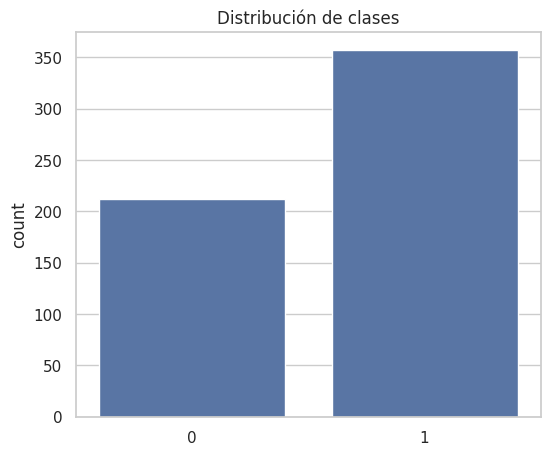

In [4]:
# Distribución de clases
sns.countplot(x=y)
plt.title("Distribución de clases")
plt.show()


- División train/test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape

((455, 30), (114, 30))

## 2. Flujo recomendado con Pipelines

Todas las técnicas se implementarán con `Pipeline`:
- Estandarización (StandardScaler)
- Modelo
- Validación cruzada

Esto asegura que la estandarización no filtre información del test set.


- Modelos base

In [6]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "SVM RBF": SVC(kernel="rbf", probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "kNN": KNeighborsClassifier()
}

results = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
    results[name] = scores
    print(f"{name}: Accuracy medio = {scores.mean():.4f} ± {scores.std():.4f}")


Logistic Regression: Accuracy medio = 0.9780 ± 0.0098
SVM RBF: Accuracy medio = 0.9692 ± 0.0146
Random Forest: Accuracy medio = 0.9626 ± 0.0179
Gradient Boosting: Accuracy medio = 0.9538 ± 0.0128
kNN: Accuracy medio = 0.9626 ± 0.0112


## 3. Comparación inicial de modelos

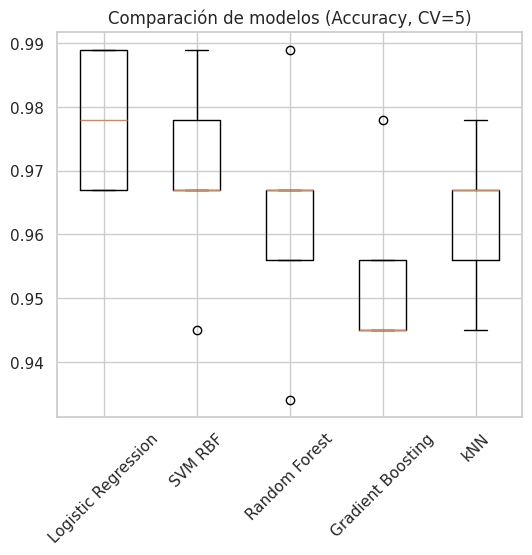

In [7]:
plt.boxplot(results.values(), labels=results.keys())
plt.title("Comparación de modelos (Accuracy, CV=5)")
plt.xticks(rotation=45)
plt.show()

## 4. Optimización de hiperparámetros: Grid Search

Buscamos hiperparámetros óptimos explorando una grilla exhaustiva.


In [8]:
param_grid = {
    "model__C": [0.1, 1, 10],
    "model__gamma": ["scale", 0.01, 0.001]
}

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(kernel="rbf", probability=True))
])

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

grid.best_params_, grid.best_score_


({'model__C': 10, 'model__gamma': 0.01}, np.float64(0.9758241758241759))

## 5. Randomized Search

Explora aleatoriamente el espacio de hiperparámetros.  
Útil cuando:
- Hay muchas combinaciones posibles  
- No queremos hacer un Grid Search completo  


In [9]:
from scipy.stats import randint

param_dist = {
    "model__n_estimators": randint(50, 400),
    "model__max_depth": randint(3, 20),
    "model__min_samples_split": randint(2, 10),
}

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier())
])

random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
random_search.best_params_, random_search.best_score_


({'model__max_depth': 9,
  'model__min_samples_split': 3,
  'model__n_estimators': 138},
 np.float64(0.964835164835165))

## 6. Halving Grid/Random Search

Métodos **sucesivos de poda** (Successive Halving):
- Empiezan evaluando muchos modelos con pocos recursos.
- Conservan los mejores y aumentan recursos en cada ronda.
- Mucho más eficientes que Grid/Random Search tradicionales.


In [10]:
param_grid = {
    "model__C": [0.1, 1, 10, 100],
    "model__gamma": ["scale", 0.1, 0.01, 0.001]
}

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(kernel="rbf"))
])

halving = HalvingGridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring="accuracy",
    factor=2,
    random_state=42
)

halving.fit(X_train, y_train)
halving.best_params_, halving.best_score_


({'model__C': 1, 'model__gamma': 0.01}, np.float64(0.9730337078651685))

## 7. Optuna (Optimización Bayesiana)

Optuna permite:

- Explorar el espacio de hiperparámetros inteligentemente (TPE).
- Pruning automático de trials malos.
- Visualizaciones avanzadas.

Entrenaremos una SVM optimizada con Optuna.


In [11]:
def objective(trial):
    C = trial.suggest_float("C", 1e-3, 100, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1, log=True)
    
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(C=C, gamma=gamma, probability=True))
    ])
    
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

study.best_params, study.best_value


[I 2025-11-23 00:08:22,697] A new study created in memory with name: no-name-258b0b0d-5c62-4028-9f7d-643a60a86e44
[I 2025-11-23 00:08:22,834] Trial 0 finished with value: 0.6263736263736264 and parameters: {'C': 0.00290350878480785, 'gamma': 0.001042742161482937}. Best is trial 0 with value: 0.6263736263736264.
[I 2025-11-23 00:08:22,965] Trial 1 finished with value: 0.7318681318681319 and parameters: {'C': 0.7572139407817773, 'gamma': 0.0001215322767904918}. Best is trial 1 with value: 0.7318681318681319.
[I 2025-11-23 00:08:23,019] Trial 2 finished with value: 0.9670329670329672 and parameters: {'C': 88.04361430427367, 'gamma': 0.00676792785367559}. Best is trial 2 with value: 0.9670329670329672.
[I 2025-11-23 00:08:23,152] Trial 3 finished with value: 0.6263736263736264 and parameters: {'C': 0.008155335265854644, 'gamma': 0.05918924407476191}. Best is trial 2 with value: 0.9670329670329672.
[I 2025-11-23 00:08:23,288] Trial 4 finished with value: 0.6263736263736264 and parameters: {

({'C': 38.04855281046854, 'gamma': 0.005098536247624597}, 0.9758241758241759)

## 9. Evaluación final del mejor modelo


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



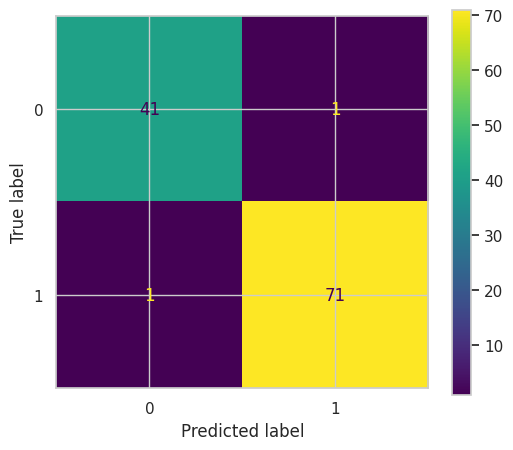

In [15]:
best_pipe = grid.best_estimator_

y_pred = best_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


# 10. Conclusiones

En este notebook aprendimos a:

- Implementar pipelines de preprocesamiento + modelo.
- Usar validación cruzada de forma correcta.
- Entrenar modelos clásicos y compararlos.
- Optimizar modelos con:
  - Grid Search
  - Randomized Search
  - Halving Search
  - Optuna

Este flujo es el estándar profesional para cualquier proyecto clásico de ML.
